# Comparación de Técnicas de Exploración vs Explotación en ALE/Boxing

In [ ]:

import gymnasium as gym
import ale_py
import numpy as np
import matplotlib.pyplot as plt
import cv2
from collections import defaultdict
from math import log, sqrt, exp


In [2]:

def discretizar(observation):
    resized = cv2.resize(observation, (5, 5))
    discretized = (resized / 255 * 5).astype(np.int32)
    return tuple(discretized.flatten())


In [3]:

def epsilon_greedy(q_table, action_counts, state, episode, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(len(q_table[state]))
    return np.argmax(q_table[state])

def greedy(q_table, action_counts, state, episode, epsilon):
    return np.argmax(q_table[state])

def softmax(q_table, action_counts, state, episode, epsilon):
    tau = 1.0
    prefs = q_table[state]
    exp_prefs = np.exp(prefs / tau)
    probs = exp_prefs / np.sum(exp_prefs)
    return np.random.choice(len(probs), p=probs)

def ucb(q_table, action_counts, state, episode, epsilon):
    total = np.sum(action_counts[state]) + 1
    ucb_values = q_table[state] + np.sqrt(2 * np.log(total) / (action_counts[state] + 1e-5))
    return np.argmax(ucb_values)


In [4]:

def train(policy_fn, episodes=100, init_q=0, render=False):
    env = gym.make("ALE/Boxing-v5", render_mode="rgb_array", obs_type="grayscale")
    q_table = defaultdict(lambda: np.full(env.action_space.n, init_q, dtype=np.float32))
    action_counts = defaultdict(lambda: np.zeros(env.action_space.n))
    rewards_per_episode = np.zeros(episodes)
    epsilon = 1.0
    epsilon_decay = 0.01

    for i in range(episodes):
        state = discretizar(env.reset()[0])
        terminated = False
        truncated = False
        total_reward = 0

        while not terminated and not truncated:
            action = policy_fn(q_table, action_counts, state, i, epsilon)
            new_state, reward, terminated, truncated, _ = env.step(action)
            new_state = discretizar(new_state)

            old_value = q_table[state][action]
            next_max = np.max(q_table[new_state])
            q_table[state][action] += 0.3 * (reward + 0.95 * next_max - old_value)
            action_counts[state][action] += 1

            state = new_state
            total_reward += reward

        rewards_per_episode[i] = total_reward
        epsilon = max(epsilon - epsilon_decay, 0)

    env.close()
    return rewards_per_episode


Entrenando con política: Epsilon-Greedy
Entrenando con política: Greedy
Entrenando con política: Softmax
Entrenando con política: UCB


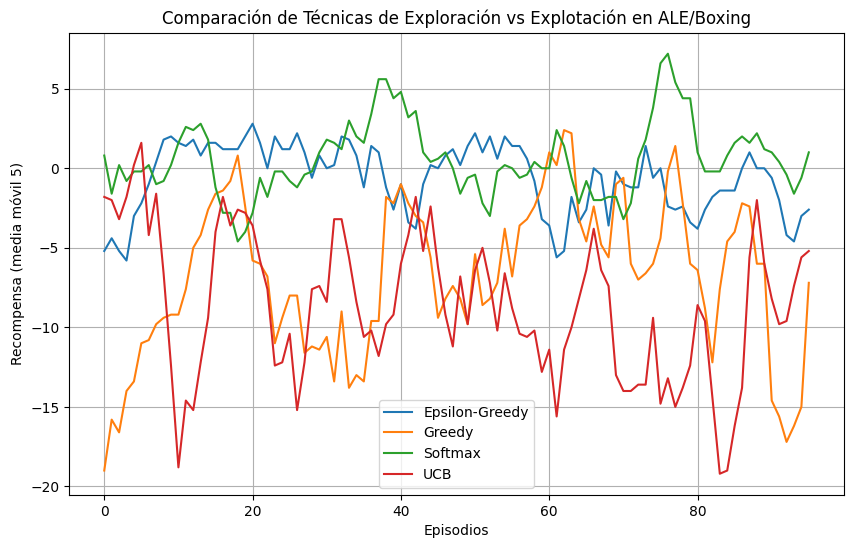

In [5]:

episodes = 100
results = {}

for name, policy in {
    "Epsilon-Greedy": epsilon_greedy,
    "Greedy": greedy,
    "Softmax": softmax,
    "UCB": ucb
}.items():
    print(f"Entrenando con política: {name}")
    rewards = train(policy, episodes)
    results[name] = rewards

plt.figure(figsize=(10, 6))
for name, rewards in results.items():
    plt.plot(np.convolve(rewards, np.ones(5)/5, mode='valid'), label=name)
plt.xlabel("Episodios")
plt.ylabel("Recompensa (media móvil 5)")
plt.title("Comparación de Técnicas de Exploración vs Explotación en ALE/Boxing")
plt.legend()
plt.grid()
plt.show()


## Evolución de Exploración vs Explotación

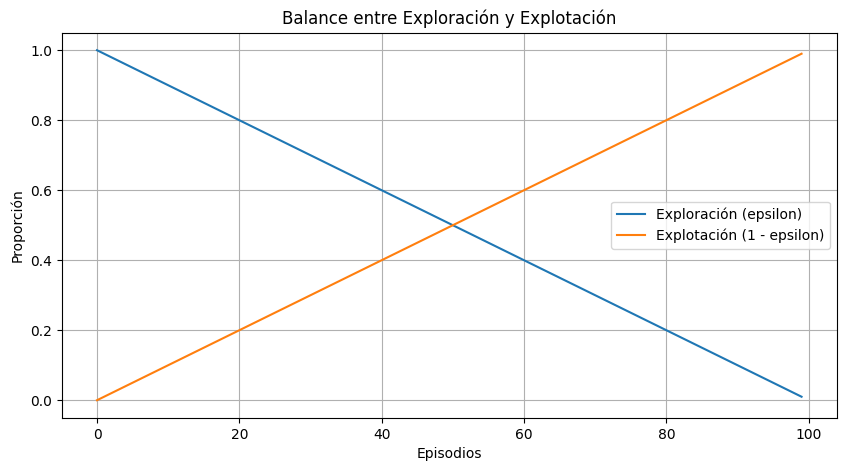

In [6]:

epsilons = []
epsilon = 1.0
epsilon_decay = 0.01
episodes = 100

for _ in range(episodes):
    epsilons.append(epsilon)
    epsilon = max(epsilon - epsilon_decay, 0)

plt.figure(figsize=(10, 5))
plt.plot(epsilons, label='Exploración (epsilon)')
plt.plot([1 - e for e in epsilons], label='Explotación (1 - epsilon)')
plt.xlabel('Episodios')
plt.ylabel('Proporción')
plt.title('Balance entre Exploración y Explotación')
plt.legend()
plt.grid()
plt.show()


## Gráfica combinada por técnica: recompensa vs exploración/explotación

Entrenando con política: Epsilon-Greedy


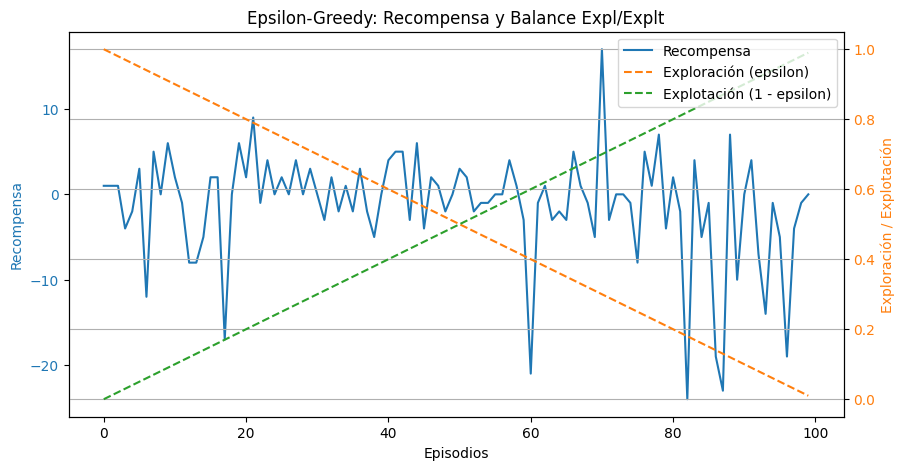

Entrenando con política: Greedy


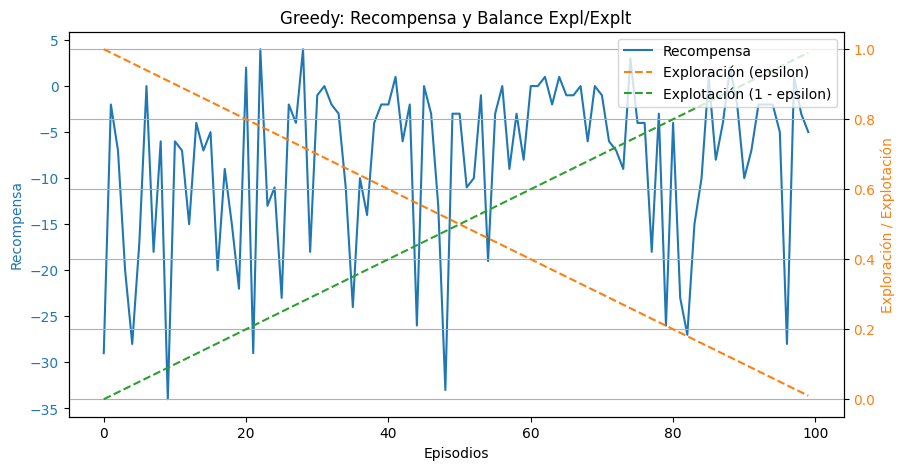

Entrenando con política: Softmax


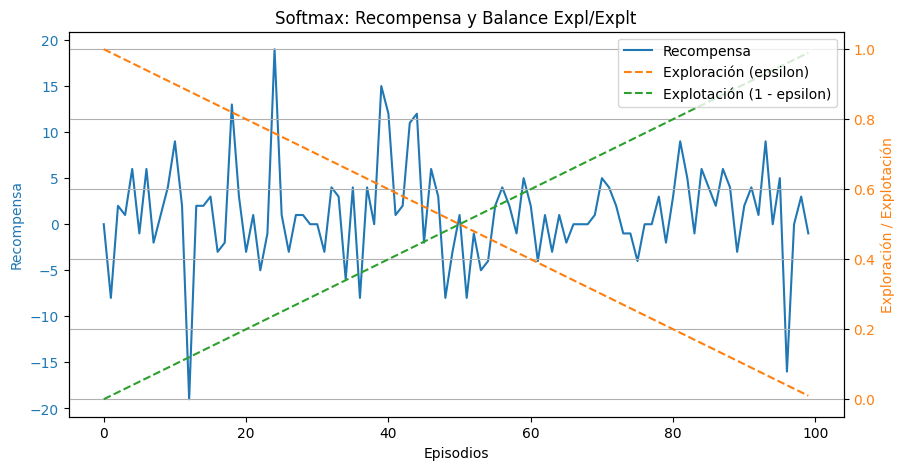

Entrenando con política: UCB


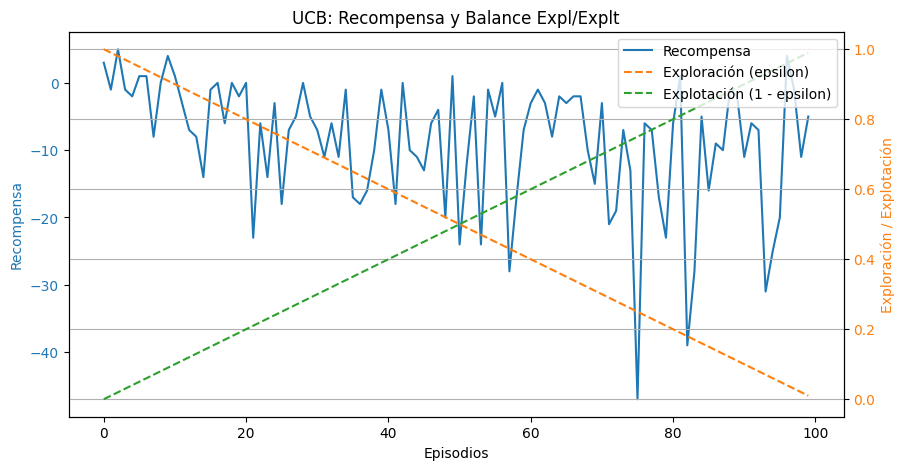

In [7]:

episodes = 100
epsilon_decay = 0.01

# Entrenamos y graficamos por técnica individualmente
for name, policy in {
    "Epsilon-Greedy": epsilon_greedy,
    "Greedy": greedy,
    "Softmax": softmax,
    "UCB": ucb
}.items():
    print(f"Entrenando con política: {name}")

    epsilon = 1.0
    epsilons = []

    # Entrenamiento personalizado para registrar recompensas y epsilons
    env = gym.make("ALE/Boxing-v5", render_mode="rgb_array", obs_type="grayscale")
    q_table = defaultdict(lambda: np.full(env.action_space.n, 0, dtype=np.float32))
    action_counts = defaultdict(lambda: np.zeros(env.action_space.n))
    rewards_per_episode = np.zeros(episodes)

    for i in range(episodes):
        epsilons.append(epsilon)
        state = discretizar(env.reset()[0])
        terminated = False
        truncated = False
        total_reward = 0

        while not terminated and not truncated:
            action = policy(q_table, action_counts, state, i, epsilon)
            new_state, reward, terminated, truncated, _ = env.step(action)
            new_state = discretizar(new_state)

            old_value = q_table[state][action]
            next_max = np.max(q_table[new_state])
            q_table[state][action] += 0.3 * (reward + 0.95 * next_max - old_value)
            action_counts[state][action] += 1

            state = new_state
            total_reward += reward

        rewards_per_episode[i] = total_reward
        epsilon = max(epsilon - epsilon_decay, 0)

    env.close()

    # Graficamos recompensa y exploración/explotación
    fig, ax1 = plt.subplots(figsize=(10, 5))

    ax1.set_xlabel('Episodios')
    ax1.set_ylabel('Recompensa', color='tab:blue')
    ax1.plot(rewards_per_episode, label='Recompensa', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Exploración / Explotación', color='tab:orange')
    ax2.plot(epsilons, label='Exploración (epsilon)', linestyle='--', color='tab:orange')
    ax2.plot([1 - e for e in epsilons], label='Explotación (1 - epsilon)', linestyle='--', color='tab:green')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    plt.title(f"{name}: Recompensa y Balance Expl/Explt")
    fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
    plt.grid()
    plt.show()
